In [2]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

# Install additional libraries
!pip install -q kaggle opencv-python scikit-learn grad-cam
!pip install -q torchvision matplotlib seaborn tqdm pillow

print("\n✅ All libraries installed successfully!")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

✅ All libraries installed successfully!


In [3]:
# Upload your kaggle.json file
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle credentials configured!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle credentials configured!


In [4]:
# Download Chest X-Ray Pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the dataset
!unzip -q chest-xray-pneumonia.zip -d ./data
!rm chest-xray-pneumonia.zip

print("Dataset downloaded and extracted!")

# Check the structure
!ls -R data/chest_xray

Streaming output truncated to the last 5000 lines.
NORMAL2-IM-0388-0001.jpeg	NORMAL2-IM-1293-0001.jpeg
NORMAL2-IM-0389-0001.jpeg	NORMAL2-IM-1294-0001-0001.jpeg
NORMAL2-IM-0390-0001.jpeg	NORMAL2-IM-1294-0001-0002.jpeg
NORMAL2-IM-0391-0001.jpeg	NORMAL2-IM-1294-0001.jpeg
NORMAL2-IM-0392-0001.jpeg	NORMAL2-IM-1295-0001.jpeg
NORMAL2-IM-0393-0001.jpeg	NORMAL2-IM-1296-0001.jpeg
NORMAL2-IM-0394-0001.jpeg	NORMAL2-IM-1300-0001.jpeg
NORMAL2-IM-0395-0001-0001.jpeg	NORMAL2-IM-1301-0001.jpeg
NORMAL2-IM-0395-0001-0002.jpeg	NORMAL2-IM-1302-0001.jpeg
NORMAL2-IM-0395-0001.jpeg	NORMAL2-IM-1303-0001.jpeg
NORMAL2-IM-0396-0001.jpeg	NORMAL2-IM-1304-0001.jpeg
NORMAL2-IM-0397-0001.jpeg	NORMAL2-IM-1305-0001.jpeg
NORMAL2-IM-0399-0001.jpeg	NORMAL2-IM-1306-0001.jpeg
NORMAL2-IM-0401-0001.jpeg	NORMAL2-IM-1307-0001.jpeg
NORMAL2-IM-0402-0001.jpeg	NORMAL2-IM-1308-0001.jpeg
NORMAL2-IM-0403-0001.jpeg	NORMAL2-IM-1310-0001.jpeg
NORMAL2-IM-0404-0001.jpeg	NORMAL2-IM-1311-0001.jpeg
NORMAL2-IM-0406-0001.jpeg	NORMAL2-IM-1314-000

In [15]:
#SETTING UP
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import random

# PyTorch imports
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [16]:
# Define paths
data_dir = Path('data/chest_xray')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

# Count images in each split
def count_images(directory):
    normal = len(list((directory / 'NORMAL').glob('*.jpeg')))
    pneumonia = len(list((directory / 'PNEUMONIA').glob('*.jpeg')))
    return normal, pneumonia

train_normal, train_pneumonia = count_images(train_dir)
val_normal, val_pneumonia = count_images(val_dir)
test_normal, test_pneumonia = count_images(test_dir)

# Create summary dataframe
summary_data = {
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'Normal': [train_normal, val_normal, test_normal,
               train_normal + val_normal + test_normal],
    'Pneumonia': [train_pneumonia, val_pneumonia, test_pneumonia,
                  train_pneumonia + val_pneumonia + test_pneumonia]
}

df_summary = pd.DataFrame(summary_data)
df_summary['Total'] = df_summary['Normal'] + df_summary['Pneumonia']
df_summary['Normal %'] = (df_summary['Normal'] / df_summary['Total'] * 100).round(2)
df_summary['Pneumonia %'] = (df_summary['Pneumonia'] / df_summary['Total'] * 100).round(2)

print("\nDataset Summary:")
print(df_summary.to_string(index=False))


Dataset Summary:
     Split  Normal  Pneumonia  Total  Normal %  Pneumonia %
     Train    1341       3875   5216     25.71        74.29
Validation       8          8     16     50.00        50.00
      Test     234        390    624     37.50        62.50
     Total    1583       4273   5856     27.03        72.97


/tmp/ipython-input-4015708506.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


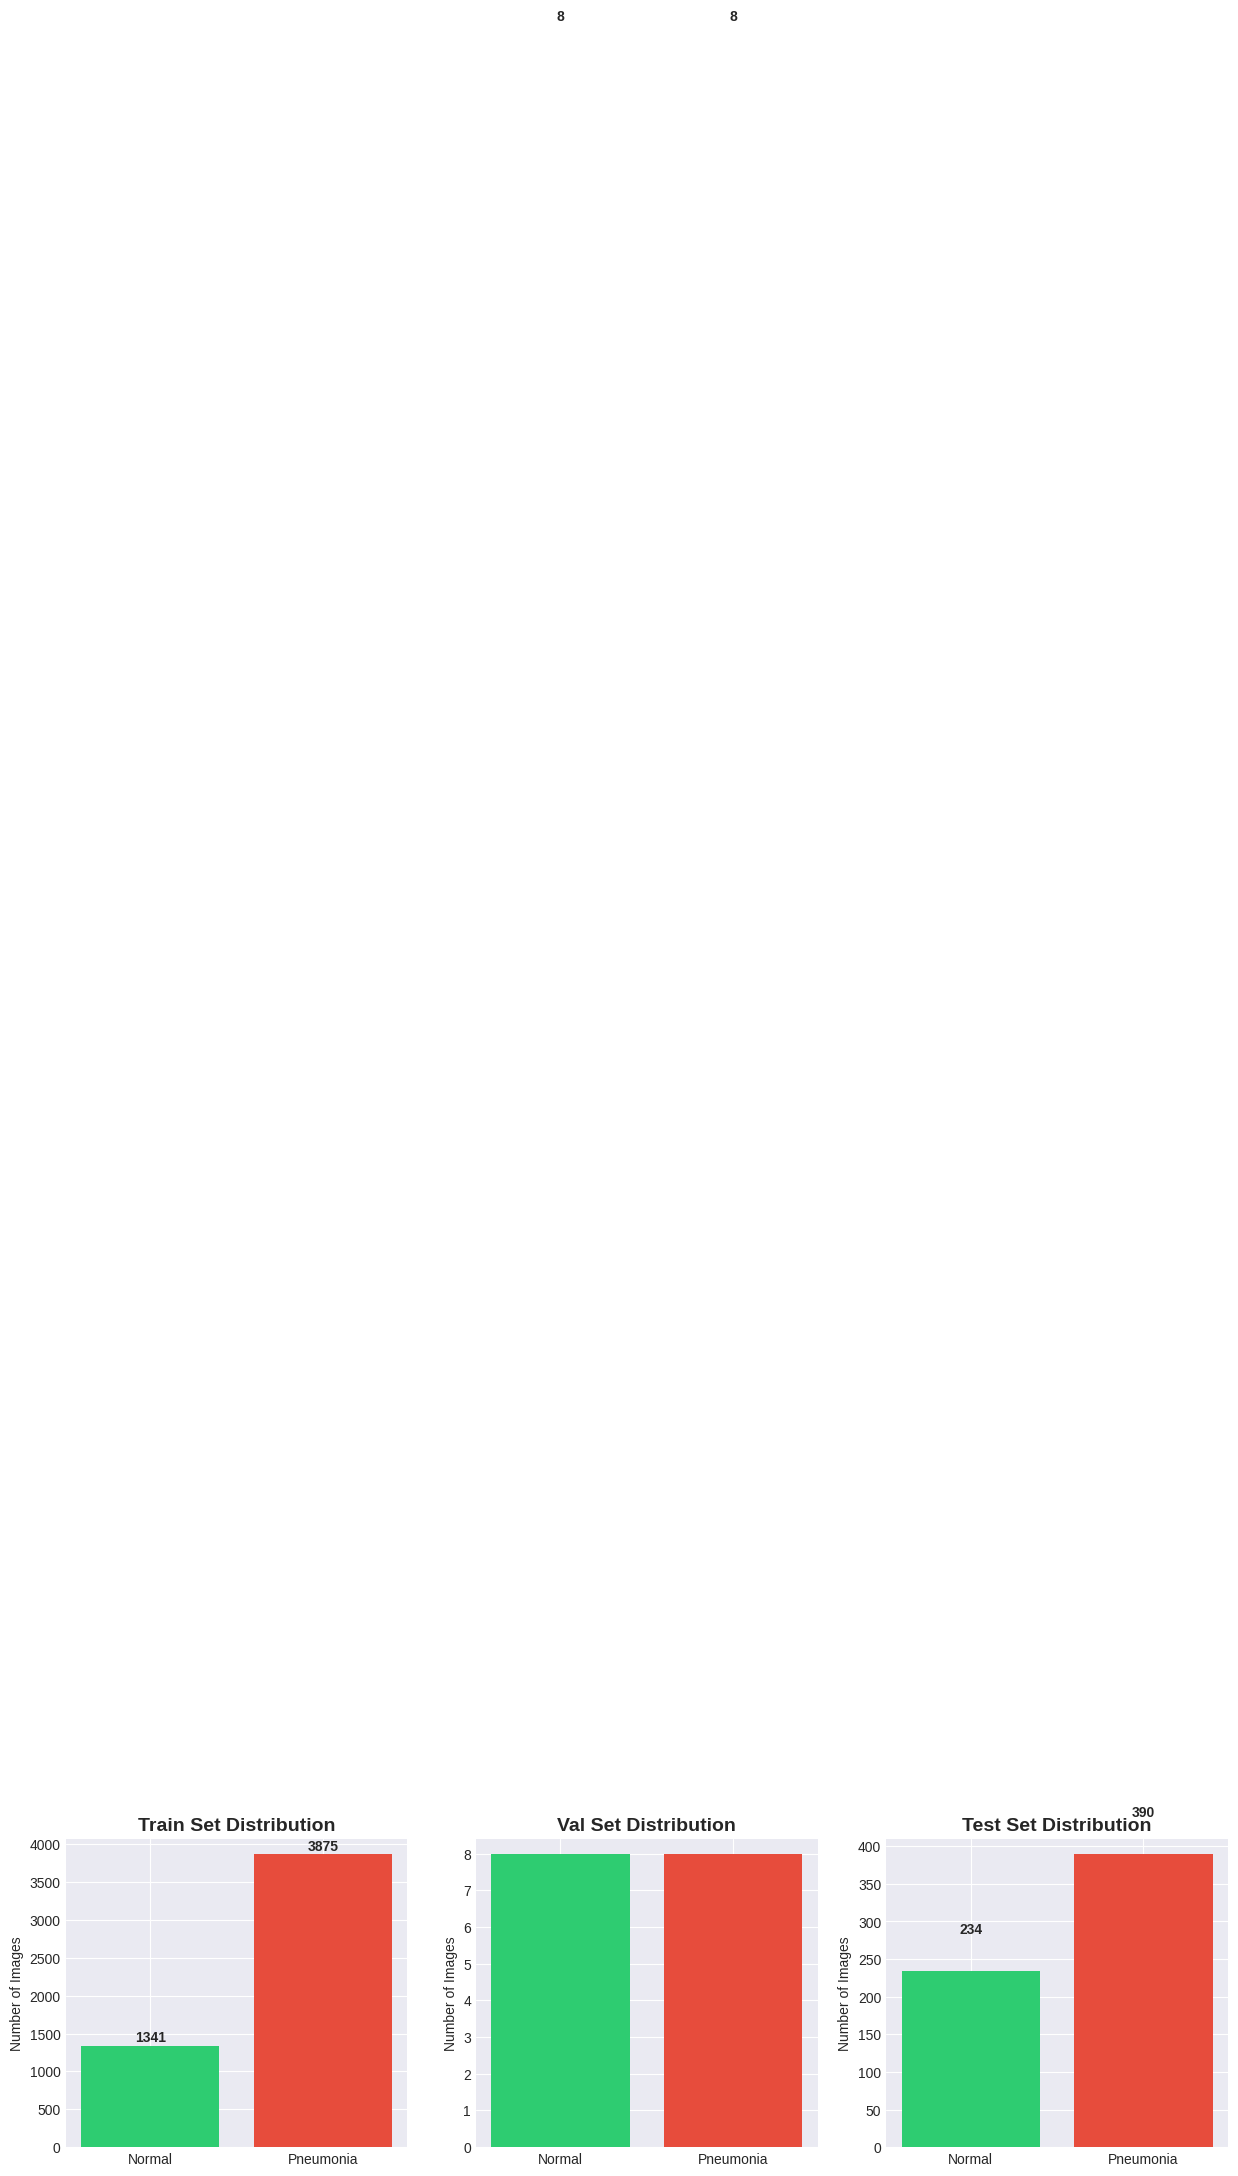

✅ Class distribution visualization saved!


In [17]:
# Visualize Class Distribution

# Create outputs directory FIRST (this is the fix!)
os.makedirs('outputs', exist_ok=True)

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

splits = ['Train', 'Val', 'Test']
data_counts = [
    [train_normal, train_pneumonia],
    [val_normal, val_pneumonia],
    [test_normal, test_pneumonia]
]

for idx, (split, counts) in enumerate(zip(splits, data_counts)):
    axes[idx].bar(['Normal', 'Pneumonia'], counts, color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{split} Set Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Number of Images')

    # Add count labels on bars
    for i, count in enumerate(counts):
        axes[idx].text(i, count + 50, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Class distribution visualization saved!")

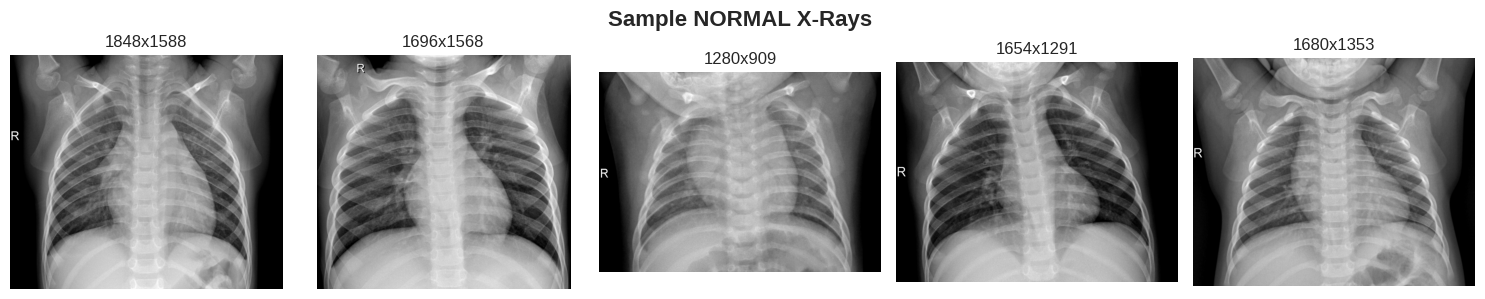

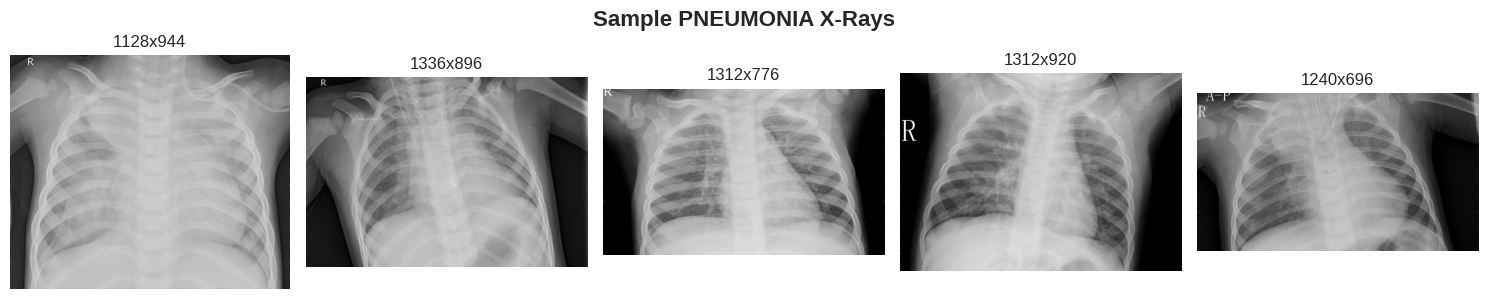

Sample images displayed!


In [18]:
# Display Sample Images
def display_samples(directory, class_name, num_samples=5):
    """Display random sample images from a class"""
    class_dir = directory / class_name
    images = list(class_dir.glob('*.jpeg'))
    samples = random.sample(images, min(num_samples, len(images)))

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle(f'Sample {class_name} X-Rays', fontsize=16, fontweight='bold')

    for idx, img_path in enumerate(samples):
        img = Image.open(img_path).convert('RGB')
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f'{img.size[0]}x{img.size[1]}')

    plt.tight_layout()
    return fig

# Display samples from both classes
fig1 = display_samples(train_dir, 'NORMAL', num_samples=5)
plt.savefig('outputs/sample_normal.png', dpi=300, bbox_inches='tight')
plt.show()

fig2 = display_samples(train_dir, 'PNEUMONIA', num_samples=5)
plt.savefig('outputs/sample_pneumonia.png', dpi=300, bbox_inches='tight')
plt.show()

print("Sample images displayed!")

Analyzing image dimensions (sampling 500 images)...


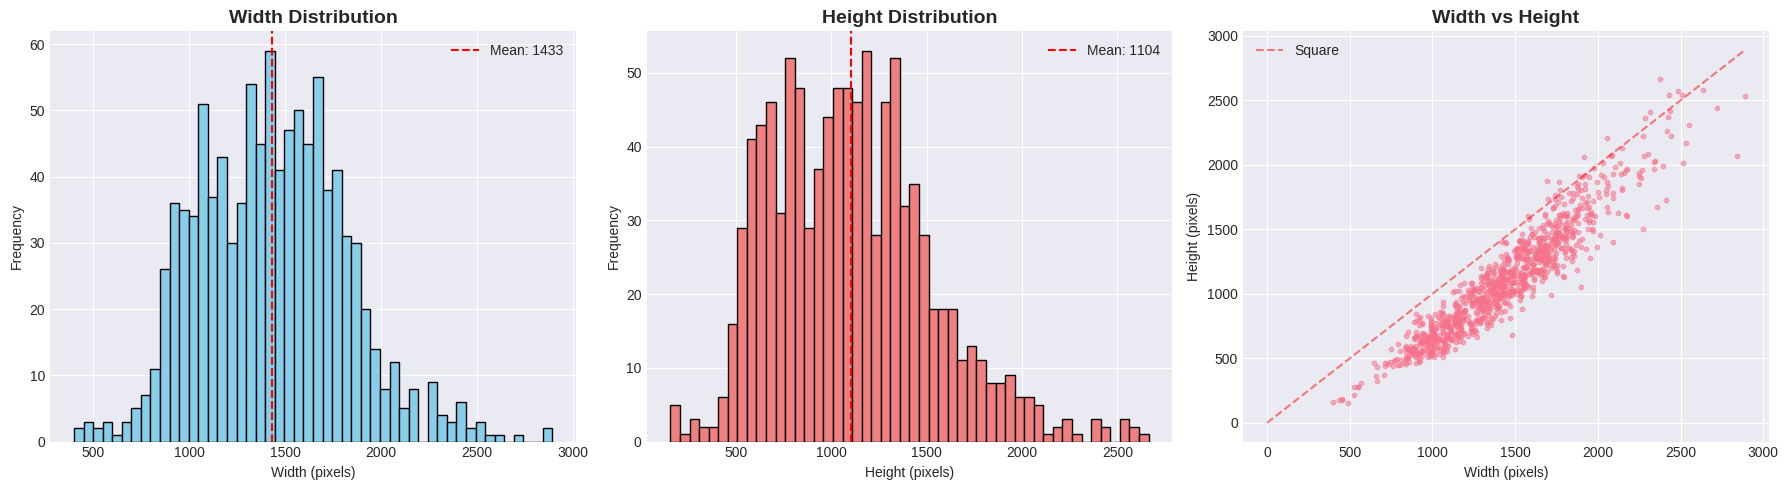


Image Dimension Statistics:
Width  - Min:  399, Max: 2890, Mean: 1433, Std: 382
Height - Min:  156, Max: 2663, Mean: 1104, Std: 418


In [19]:
# Analyze Image Dimensions
def get_image_stats(directory, sample_size=500):
    """Get statistics about image dimensions"""
    widths, heights = [], []

    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = directory / class_name
        images = list(class_dir.glob('*.jpeg'))
        samples = random.sample(images, min(sample_size, len(images)))

        for img_path in samples:
          img = Image.open(img_path)
          widths.append(img.size[0])
          heights.append(img.size[1])

    return widths, heights

# Get image dimensions
print("Analyzing image dimensions (sampling 500 images)...")
widths, heights = get_image_stats(train_dir)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


# Width distribution
axes[0].hist(widths, bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Width Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(widths), color='red', linestyle='--',
                label=f'Mean: {np.mean(widths):.0f}')
axes[0].legend()

# Height distribution
axes[1].hist(heights, bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Height Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(heights), color='red', linestyle='--',
                label=f'Mean: {np.mean(heights):.0f}')
axes[1].legend()

# Scatter plot
axes[2].scatter(widths, heights, alpha=0.5, s=10)
axes[2].set_title('Width vs Height', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Width (pixels)')
axes[2].set_ylabel('Height (pixels)')
axes[2].plot([0, max(widths)], [0, max(widths)], 'r--', alpha=0.5, label='Square')
axes[2].legend()

plt.tight_layout()
plt.savefig('outputs/image_dimensions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\nImage Dimension Statistics:")
print(f"Width  - Min: {min(widths):4d}, Max: {max(widths):4d}, Mean: {np.mean(widths):.0f}, Std: {np.std(widths):.0f}")
print(f"Height - Min: {min(heights):4d}, Max: {max(heights):4d}, Mean: {np.mean(heights):.0f}, Std: {np.std(heights):.0f}")





In [20]:
# Key Observations Summary
imbalance_ratio = train_pneumonia / train_normal

print("\n" + "="*60)
print("KEY OBSERVATIONS FROM EDA")
print("="*60)

print(f"\n1. Dataset Size:")
print(f"   - Total images: {train_normal + train_pneumonia + val_normal + val_pneumonia + test_normal + test_pneumonia}")
print(f"   - Training: {train_normal + train_pneumonia}")
print(f"   - Validation: {val_normal + val_pneumonia}")
print(f"   - Test: {test_normal + test_pneumonia}")

print(f"\n2. Class Imbalance:")
print(f"   - Training set is {'IMBALANCED' if imbalance_ratio > 1.5 or imbalance_ratio < 0.67 else 'BALANCED'}")
print(f"   - Pneumonia/Normal ratio: {imbalance_ratio:.2f}:1")
print(f"   - Will use class weights + K-Fold CV to handle this!")

print(f"\n3. Image Dimensions:")
print(f"   - Images have varying sizes (not uniform)")
print(f"   - Will resize to 224x224 for transfer learning")
print(f"   - Mean size: {np.mean(widths):.0f}x{np.mean(heights):.0f} pixels")

print(f"\n4. Strategy for Small Validation Set:")
print(f"   - Current val set: only 16 images (TOO SMALL)")
print(f"   - Solution: Will use 5-Fold Cross Validation")
print(f"   - This gives us 5 different validation sets")

print(f"\n5. Next Steps:")
print(f"   ✓ Build data preprocessing pipeline with augmentation")
print(f"   ✓ Calculate class weights for imbalanced data")
print(f"   ✓ Implement K-Fold cross validation")
print(f"   ✓ Use transfer learning with ResNet50")

print("\n" + "="*60)
print("DAY 1 EDA COMPLETE! Ready for Day 2 preprocessing")
print("="*60)


KEY OBSERVATIONS FROM EDA

1. Dataset Size:
   - Total images: 5856
   - Training: 5216
   - Validation: 16
   - Test: 624

2. Class Imbalance:
   - Training set is IMBALANCED
   - Pneumonia/Normal ratio: 2.89:1
   - Will use class weights + K-Fold CV to handle this!

3. Image Dimensions:
   - Images have varying sizes (not uniform)
   - Will resize to 224x224 for transfer learning
   - Mean size: 1433x1104 pixels

4. Strategy for Small Validation Set:
   - Current val set: only 16 images (TOO SMALL)
   - Solution: Will use 5-Fold Cross Validation
   - This gives us 5 different validation sets

5. Next Steps:
   ✓ Build data preprocessing pipeline with augmentation
   ✓ Calculate class weights for imbalanced data
   ✓ Implement K-Fold cross validation
   ✓ Use transfer learning with ResNet50

DAY 1 EDA COMPLETE! Ready for Day 2 preprocessing


In [21]:
# Save Summary Report
report = f"""
# Day 1 EDA Report - MediScan-AI

**Date:** {pd.Timestamp.now().strftime('%Y-%m-%d')}

## Dataset Overview
- Total Images: {train_normal + train_pneumonia + val_normal + val_pneumonia + test_normal + test_pneumonia}
- Classes: Normal (0), Pneumonia (1)

## Class Distribution
{df_summary.to_string(index=False)}

## Image Statistics
- Width: {np.mean(widths):.0f} ± {np.std(widths):.0f} pixels
- Height: {np.mean(heights):.0f} ± {np.std(heights):.0f} pixels
- Size range: {min(widths)}x{min(heights)} to {max(widths)}x{max(heights)}

## Key Findings
1. Severe validation set limitation (only 16 images)
2. Class imbalance in training (ratio: {imbalance_ratio:.2f}:1)
3. Variable image dimensions - will standardize to 224x224
4. Adequate training data (5,216 images)
5. Good test set size (624 images)

## Solutions Planned
- Use K-Fold Cross Validation (5 folds)
- Apply class weights during training
- Implement heavy data augmentation
- Monitor multiple metrics (not just accuracy)

## Status
Day 1 Complete.

## Files Generated
- outputs/class_distribution.png
- outputs/sample_normal.png
- outputs/sample_pneumonia.png
- outputs/image_dimensions.png
- outputs/day1_report.txt
"""

with open('outputs/day1_report.txt', 'w') as f:
    f.write(report)

print("Report saved to outputs/day1_report.txt")
print("\n🎉 DAY 1 COMPLETE! Now committing to GitHub!")

Report saved to outputs/day1_report.txt

🎉 DAY 1 COMPLETE! Now committing to GitHub!
